In [1]:
import networkx as nx

In [143]:
nodes = {"ABCD": 1, "ABC": 2, "AB": 3, "A": 1}  # node and count

G = nx.DiGraph()
for u in nodes.keys():
    G.add_node(u, count=nodes[u])

for u in nodes.keys():
    for v in nodes.keys():
        if v in u and u != v:
            G.add_edge(u, v, weight=nodes[v])

G.edges(data=True)

OutEdgeDataView([('ABCD', 'ABC', {'weight': 2}), ('ABCD', 'AB', {'weight': 3}), ('ABCD', 'A', {'weight': 1}), ('ABC', 'AB', {'weight': 3}), ('ABC', 'A', {'weight': 1}), ('AB', 'A', {'weight': 1})])

In [144]:
list(G.nodes(data=True))

[('ABCD', {'count': 1}),
 ('ABC', {'count': 2}),
 ('AB', {'count': 3}),
 ('A', {'count': 1})]

In [145]:
def get_p(G, source, target):
    out_edges = sum([edge[2]["weight"] for edge in G.edges(source, data=True)])
    node_cnt = G.nodes(data=True)[target]["count"]
    p = node_cnt / out_edges  # nodes in current "layer" / all outgoing edges
    return p


print(get_p(G, "ABCD", "ABC"))

0.3333333333333333


In [146]:
def get_paths(G, source, target):
    return list(nx.all_simple_paths(G, source, target))


paths = get_paths(G, "ABCD", "A")
paths

[['ABCD', 'ABC', 'AB', 'A'],
 ['ABCD', 'ABC', 'A'],
 ['ABCD', 'AB', 'A'],
 ['ABCD', 'A']]

In [150]:
def get_path_prob(G, source, target):
    paths = get_paths(G, source, target)
    path_probs = []
    for path in paths:
        probs = []
        for i in range(len(path) - 1):
            probs.append(get_p(G, path[i], path[i + 1]))
        prob = 1
        for p in probs:
            prob *= p
        path_probs.append((path, prob))
    return path_probs


path_probs = get_path_prob(G, "ABCD", "A")
path_probs

[(['ABCD', 'ABC', 'AB', 'A'], 0.25),
 (['ABCD', 'ABC', 'A'], 0.08333333333333333),
 (['ABCD', 'AB', 'A'], 0.5),
 (['ABCD', 'A'], 0.16666666666666666)]

In [151]:
def get_path_length(path_probs):
    length = 0
    for path_prob in path_probs:
        l = len(path_prob[0]) - 1
        p = path_prob[1]
        length += l * p
    return length


get_path_length(path_probs)

2.083333333333333

# Simulate proteolysis


In [29]:
pr39 = "METQRASLCLGRWSLWLLLLGLVVPSASAQALSYREAVLRAVDRLNEQSSEANLYRLLELDQPPKADEDPGTPKPVSFTVKETVCPRPTRQPPELCDFKENGRVKQCVGTVTLNPSIHSLDISCNEIQSVRRRPRPPYLPRPRPPPFFPPRLPPRIPPGFPPRFPPRFPGKR"
pr39_trunc = "METQRASLCLGRWSLWLLLLGLVVPSASAQALSYREAVLRAVDRLNEQSSEANLYRLLELDQPPKADEDPGTPKPVSFTVKETVCPRPTRQPPELCDFKENGR"

amino_acids = {
    "VAL": "V",
    "ILE": "I",
    "LEU": "L",
    "GLU": "E",
    "GLN": "Q",
    "ASP": "D",
    "ASN": "N",
    "HIS": "H",
    "TRP": "W",
    "PHE": "F",
    "TYR": "Y",
    "ARG": "R",
    "LYS": "K",
    "SER": "S",
    "THR": "T",
    "MET": "M",
    "ALA": "A",
    "GLY": "G",
    "PRO": "P",
    "CYS": "C",
}


class enzyme:
    """
    Enzyme with p1 specificity
    """

    def __init__(self, specificity: dict, name: str):
        self.specificity = specificity
        assert sum(specificity.values()) - 1 < 0.001
        self.aas = list(specificity.keys())
        self.name = name


protease_iv = enzyme({"K": 1}, "protease_iv")
trypsin = enzyme({"K": 0.5, "R": 0.5}, "trypsin")
elne = enzyme({"V": 0.5, "I": 0.25, "A": 0.15, "T": 0.1}, "elne")
unspecific = enzyme(
    {v: 1 / len(amino_acids.values()) for v in amino_acids.values()}, "unspecific"
)


class enzyme_set:
    def __init__(self, enzymes: list, activities: list):
        total_activity = sum(activities)
        activities = [a / total_activity for a in activities]
        assert len(enzymes) == len(activities)
        self.enzyme_dict = {e: a for e, a in zip(enzymes, activities)}

    def get_enzyme(self, name):
        for enzyme in self.enzyme_dict.keys():
            if enzyme.name == name:
                return enzyme
        print("enzyme not in dict")
        return None


enzymes = enzyme_set([protease_iv, trypsin, elne], [3, 2, 3])

In [96]:
def find_aminoacids_in_sequence(protein_sequence, target_aminoacid):
    return [i for i, aa in enumerate(protein_sequence) if aa == target_aminoacid]


n_start = 100  # copy number of starting sequence
n_iterations = 500  # how many iterations to run proteolysis
starting_sequence = pr39

import networkx as nx
import numpy as np

sequence_dict = {starting_sequence: n_start}  # a dict with sequence:copy_number
sequence_graph = (
    nx.DiGraph()
)  # a weighted graph, telling us how degradation has occured
sequence_graph.add_node(starting_sequence, len=len(starting_sequence))

"""
At every iteration we want to:

1. Draw number N1 for endoprotease cuts
2. Draw number N2 for exoprotease cuts
3. Get the sum(N_cutsites*specificity). This * activity is probability for cut
4. For selected enzyme, perform a cut
5. Repeat N1 times.
6. After each cut, note the origin and target. Keep targets in sequence_dict and 
fill the graph with each origin-target cut.

"""


def get_cut_probability(sequence_dict: dict, enzymes: enzyme_set) -> dict:
    """
    Returns probability for enzyme cut given enzymes and sequences
    """
    freqs = {}
    for enzyme, activity in enzymes.enzyme_dict.items():
        specificities = enzyme.specificity
        freq = 0
        for sequence, copy_number in sequence_dict.items():
            for aminoacid, specificity in specificities.items():
                n_cut_sites = len(find_aminoacids_in_sequence(sequence, aminoacid))
                freq += n_cut_sites * specificity * activity * copy_number
        freqs[enzyme.name] = freq
    probs = {k: v / sum(freqs.values()) for k, v in freqs.items()}
    return probs


def update_sequence_dict(sequence_dict : dict, source_sequence, target_sequence, endo_or_exo : str):
    if endo_or_exo == "endo":mult_factor = 0.5
    else:mult_factor = 1
    sequence_dict[source_sequence] -= 1 * mult_factor
    if sequence_dict[source_sequence] == 0:
        sequence_dict.pop(source_sequence)
    if target_sequence in sequence_dict.keys():
        sequence_dict[target_sequence] += 1
    else:
        sequence_dict[target_sequence] = 1
    return sequence_dict

def update_sequence_graph(sequence_graph : nx.DiGraph, source_sequence, target_sequence):
    if target_sequence not in sequence_graph.nodes():
        sequence_graph.add_node(target_sequence, len=len(target_sequence))

    if ~sequence_graph.has_edge(source_sequence, target_sequence):
        sequence_graph.add_edge(source_sequence, target_sequence, n=1)
    else:
        previous_n = sequence_graph.get_edge_data(source_sequence, target_sequence)["n"]
        new_n = previous_n + 1
        sequence_graph[source_sequence][target_sequence]["n"] = new_n
    return sequence_graph

for _ in range(n_iterations):
    exo_or_endo = np.random.choice(["exo", "endo"], p=[0.5, 0.5])
    if exo_or_endo == "exo":
        sequences_longer_than_2 = [s for s in sequence_dict.keys() if len(s)>2]
 
        sequence_to_chew = np.random.choice(
            sequences_longer_than_2,
            p=[sequence_dict[v] / sum([sequence_dict[s] for s in sequences_longer_than_2]) for v in sequences_longer_than_2],
        )
        
        n_or_c_term = np.random.choice(["n", "c"], p =[0.5, 0.5])
        if n_or_c_term == "n": new_sequence = sequence_to_chew[1:]
        else: new_sequence = sequence_to_chew[:-1]
        sequence_dict = update_sequence_dict(sequence_dict, sequence_to_chew, new_sequence, endo_or_exo="exo")
        sequence_graph = update_sequence_graph(sequence_graph, sequence_to_chew, new_sequence)

    elif exo_or_endo == "endo":
        cut_probabilities = get_cut_probability(sequence_dict, enzymes)
        enzyme_that_will_cut = np.random.choice(list(cut_probabilities.keys()), p=list(cut_probabilities.values()))
        e : enzyme = enzymes.get_enzyme(enzyme_that_will_cut)
        
        # Here I say that p(sequence) is prop. to n_cutsites * copy_number. This might not be true. Maybe only copy_number.
        sequence_frequencies = {} 
        for sequence in sequence_dict.keys():
            n_cut_sites_in_sequence = 0
            for aminoacid in e.specificity.keys():
                n_cut_sites_in_sequence += len(find_aminoacids_in_sequence(sequence, aminoacid)) * e.specificity[aminoacid]
            sequence_frequencies[sequence] = n_cut_sites_in_sequence * sequence_dict[sequence]

        sequence_to_cut  = np.random.choice(list(sequence_frequencies.keys()), 
                                            p=[p / sum(sequence_frequencies.values()) for 
                                            p in sequence_frequencies.values()])

        index_to_cut = {}
        for aminoacid in e.specificity.keys():
            indices_for_aminoacid = find_aminoacids_in_sequence(sequence_to_cut, aminoacid)
            for index in indices_for_aminoacid:
                if index != len(sequence_to_cut):
                    index_to_cut[index] = e.specificity[aminoacid]
        
        cutting_index = np.random.choice(list(index_to_cut.keys()), p = [p / sum(index_to_cut.values()) for p  in index_to_cut.values()])
        left = sequence_to_cut[:cutting_index+1]
        right = sequence_to_cut[cutting_index+1:]
        sequence_dict = update_sequence_dict(sequence_dict, sequence_to_cut, left, endo_or_exo="endo")
        sequence_dict = update_sequence_dict(sequence_dict, sequence_to_cut, right, endo_or_exo="endo")
        sequence_graph = update_sequence_graph(sequence_graph, sequence_to_cut, left)
        sequence_graph = update_sequence_graph(sequence_graph, sequence_to_cut, right)


(array([50., 46., 42., 42., 28., 22.,  9.,  5.,  4.,  6.]),
 array([  0. ,  17.2,  34.4,  51.6,  68.8,  86. , 103.2, 120.4, 137.6,
        154.8, 172. ]),
 <BarContainer object of 10 artists>)

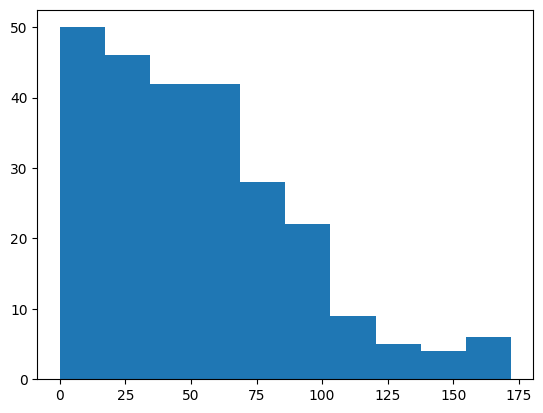

In [97]:
import matplotlib.pyplot as plt

plt.hist([len(s) for s in sequence_dict.keys()])